<a href="https://colab.research.google.com/github/Haikal7090/DSA_Eruditio/blob/main/catboost_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
!pip install gdown
!gdown --fuzzy "https://drive.google.com/file/d/1BN8Jiypz-fCpCO797jldTfQldPIGOJTi/view?usp=sharing"
!gdown --fuzzy "https://drive.google.com/file/d/1sJUJMQA_2b50yvF4WEGsWvlUrADzVUJz/view?usp=sharing"

Downloading...
From: https://drive.google.com/uc?id=1BN8Jiypz-fCpCO797jldTfQldPIGOJTi
To: /content/train.csv
100% 1.85M/1.85M [00:00<00:00, 18.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sJUJMQA_2b50yvF4WEGsWvlUrADzVUJz
To: /content/test.csv
100% 511k/511k [00:00<00:00, 8.12MB/s]


In [ ]:
# Membaca file CSV

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


In [ ]:
# Mengecek dan mengganti nilai 0 menjadi NaN di setiap kolom
df_train = df_train.replace(0, np.nan)
df_train.isnull().sum()

,0
ID,0
date,0
cluster_id,0
electricity_consumption,0
temperature_2m_max,0
temperature_2m_min,37
apparent_temperature_max,9
apparent_temperature_min,56
sunshine_duration,76
daylight_duration,0


In [ ]:
# Mengecek dan mengganti nilai 0 menjadi NaN di setiap kolom
df_test = df_test.replace(0, np.nan)
df_test.isnull().sum()

,0
ID,0
date,0
cluster_id,0
temperature_2m_max,0
temperature_2m_min,6
apparent_temperature_max,3
apparent_temperature_min,15
sunshine_duration,25
daylight_duration,0
wind_speed_10m_max,0


In [ ]:
# Pastikan numerical_cols sudah terdefinisi, jika belum, definisikan di sini
numerical_cols = [
    'electricity_consumption',
    'temperature_2m_max',
    'temperature_2m_min',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'sunshine_duration',
    'daylight_duration',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration'
]

# Menghapus outlier pada semua kolom numerik berdasarkan IQR untuk setiap cluster
def remove_outliers_all_cols_iqr_per_cluster(df_df_train, cols):
    cleaned = []
    for cluster in df_train['cluster_id'].unique():
        cluster_df =df_train[df_df_train['cluster_id'] == cluster]
        mask = pd.Series([True] * len(cluster_df), index=cluster_df.index)
        for col in cols:
            Q1 = cluster_df[col].quantile(0.25)
            Q3 = cluster_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            mask &= (cluster_df[col] >= lower_bound) & (cluster_df[col] <= upper_bound)
        cleaned.append(cluster_df[mask])
    return pd.concat(cleaned, ignore_index=True)

df_no_outlier_all = remove_outliers_all_cols_iqr_per_cluster(df_train, numerical_cols)
df_no_outlier_all.shape

(11207, 15)

In [ ]:
# Mengisi nilai kosong pada df_no_outlier_all menggunakan interpolasi linier
df_filled = df_no_outlier_all.interpolate(method='linear', limit_direction='both')

# Mengambil data outlier yang telah dihapus daridf_train
outliers =df_train[~df_train.index.isin(df_no_outlier_all.index)]

# Mengisi nilai kosong pada outlier menggunakan interpolasi linier
outliers_filled = outliers.interpolate(method='linear', limit_direction='both')

# Menggabungkan kembali data hasil interpolasi
final_df = pd.concat([df_filled, outliers_filled], ignore_index=True)

# Cek hasil
final_df.info()
final_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11688 entries, 0 to 11687
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           11688 non-null  object 
 1   date                         11688 non-null  object 
 2   cluster_id                   11688 non-null  object 
 3   electricity_consumption      11688 non-null  float64
 4   temperature_2m_max           11688 non-null  float64
 5   temperature_2m_min           11688 non-null  float64
 6   apparent_temperature_max     11688 non-null  float64
 7   apparent_temperature_min     11688 non-null  float64
 8   sunshine_duration            11688 non-null  float64
 9   daylight_duration            11688 non-null  float64
 10  wind_speed_10m_max           11688 non-null  float64
 11  wind_gusts_10m_max           11688 non-null  float64
 12  wind_direction_10m_dominant  11688 non-null  float64
 13  shortwave_radiat

/tmp/ipython-input-7-3780546543.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_filled = df_no_outlier_all.interpolate(method='linear', limit_direction='both')
/tmp/ipython-input-7-3780546543.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  outliers_filled = outliers.interpolate(method='linear', limit_direction='both')


,0
ID,0
date,0
cluster_id,0
electricity_consumption,0
temperature_2m_max,0
temperature_2m_min,0
apparent_temperature_max,0
apparent_temperature_min,0
sunshine_duration,0
daylight_duration,0


In [ ]:
# prompt: buatkan aku kode yang dapat mengisi nilai kosong dari df_test menggunakan interpolasi

# Mengisi nilai kosong pada df_test menggunakan interpolasi linier
df_test_filled = df_test.interpolate(method='linear', limit_direction='both')

# Cek hasil
df_test_filled.info()
df_test_filled.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           3400 non-null   object 
 1   date                         3400 non-null   object 
 2   cluster_id                   3400 non-null   object 
 3   temperature_2m_max           3400 non-null   float64
 4   temperature_2m_min           3400 non-null   float64
 5   apparent_temperature_max     3400 non-null   float64
 6   apparent_temperature_min     3400 non-null   float64
 7   sunshine_duration            3400 non-null   float64
 8   daylight_duration            3400 non-null   float64
 9   wind_speed_10m_max           3400 non-null   float64
 10  wind_gusts_10m_max           3400 non-null   float64
 11  wind_direction_10m_dominant  3400 non-null   float64
 12  shortwave_radiation_sum      3400 non-null   float64
 13  et0_fao_evapotrans

/tmp/ipython-input-8-3336459667.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_test_filled = df_test.interpolate(method='linear', limit_direction='both')


,0
ID,0
date,0
cluster_id,0
temperature_2m_max,0
temperature_2m_min,0
apparent_temperature_max,0
apparent_temperature_min,0
sunshine_duration,0
daylight_duration,0
wind_speed_10m_max,0


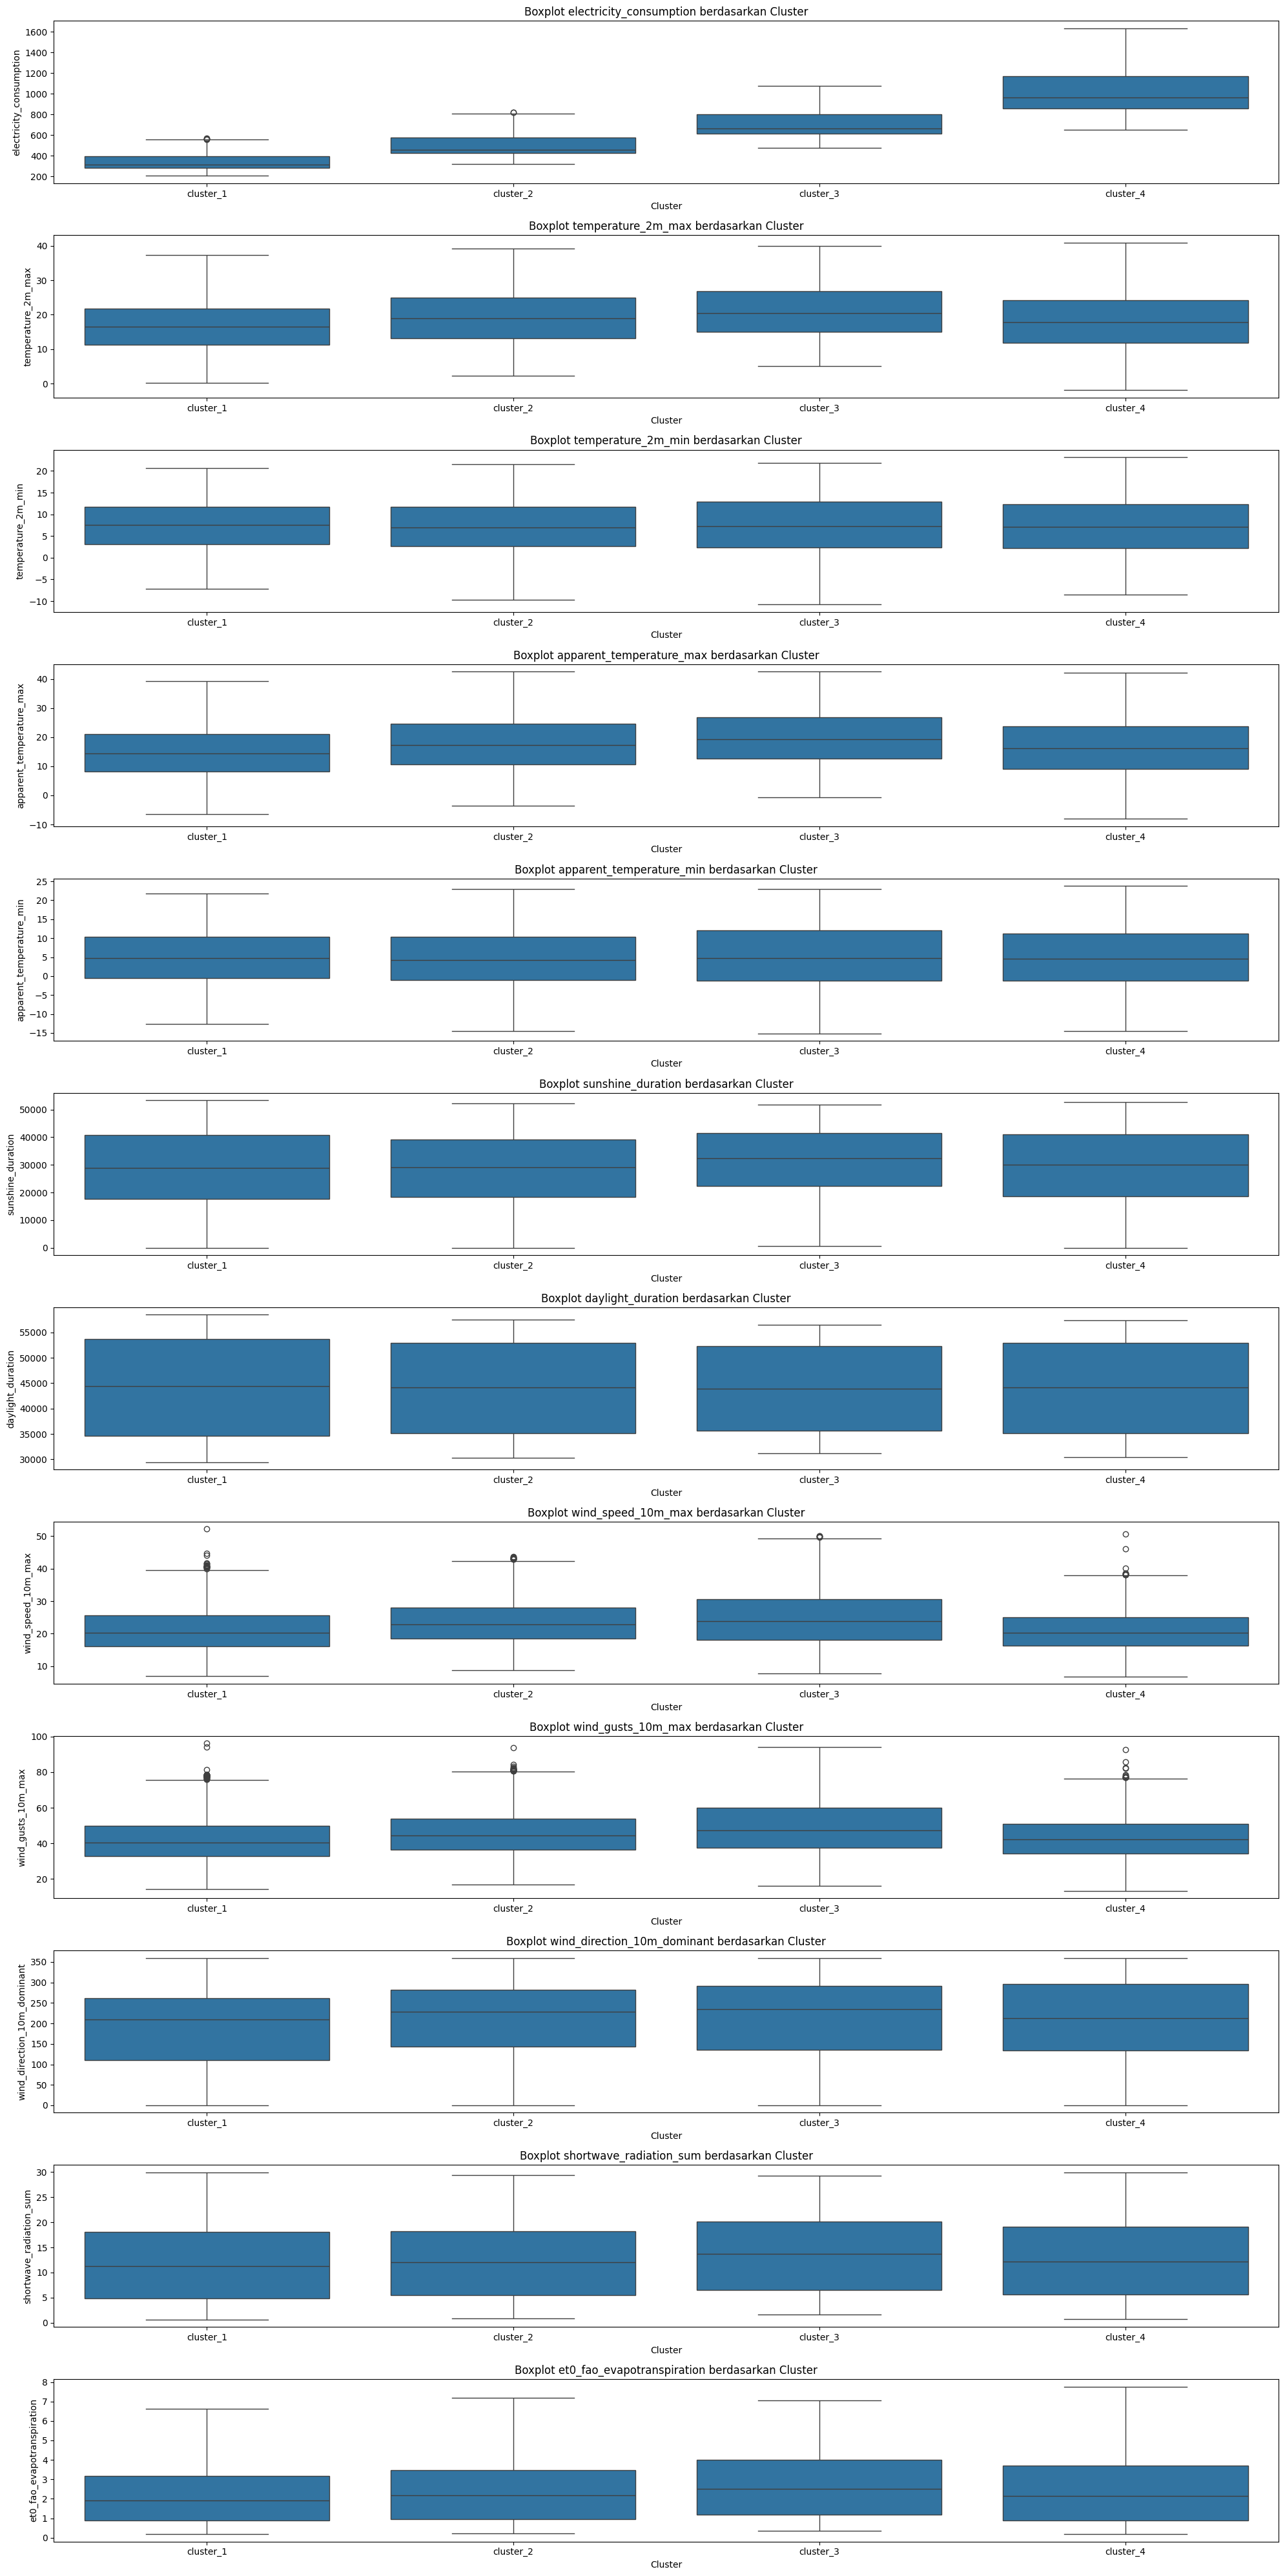

In [ ]:
# Membuat boxplot untuk setiap kolom numerik berdasarkan cluster
plt.figure(figsize=(20, 40))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.boxplot(data=final_df, x='cluster_id', y=col)
    plt.title(f'Boxplot {col} berdasarkan Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


1️⃣ Memulai Pra-pemrosesan Data...

2️⃣ Memulai Feature Engineering...
Feature engineering selesai.

3️⃣ Melakukan Splitting Validasi Internal...
Cluster cluster_1: Train split = 2161, Val split = 731
Cluster cluster_2: Train split = 2161, Val split = 731
Cluster cluster_3: Train split = 2161, Val split = 731
Cluster cluster_4: Train split = 2161, Val split = 731

4️⃣ Memulai Training dan Validasi Model Per Cluster...
Training model untuk Cluster cluster_1...
-> Cluster cluster_1 Validation Metrics: MAE = 8.2352, RMSE = 12.2880
Training model untuk Cluster cluster_2...
-> Cluster cluster_2 Validation Metrics: MAE = 11.8338, RMSE = 16.8332
Training model untuk Cluster cluster_3...
-> Cluster cluster_3 Validation Metrics: MAE = 16.5250, RMSE = 23.7278
Training model untuk Cluster cluster_4...
-> Cluster cluster_4 Validation Metrics: MAE = 25.4151, RMSE = 34.4795

5️⃣ Melatih Ulang Model Final dan Membuat Prediksi...
Retraining dan prediksi untuk Cluster cluster_1...
Retraining dan predik

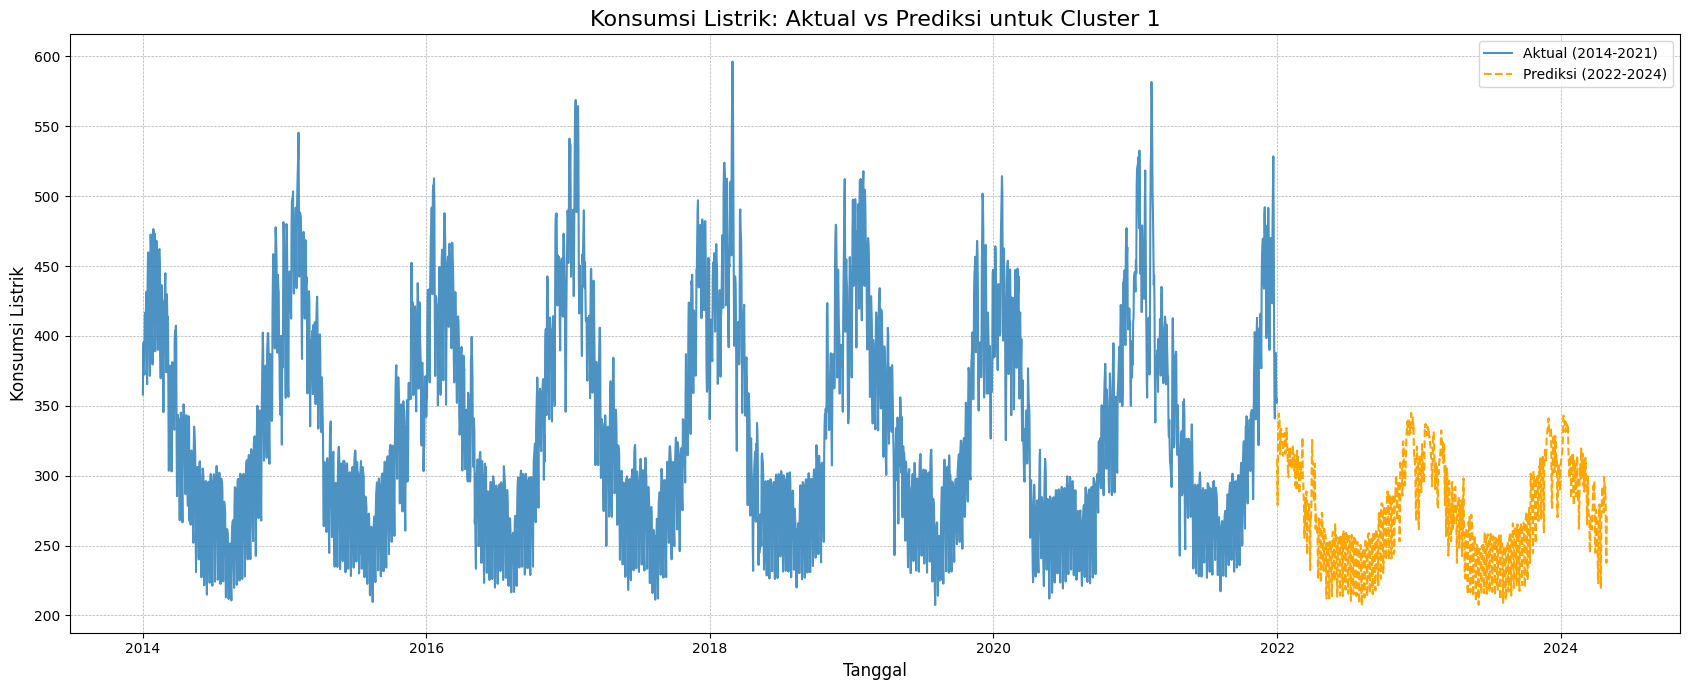

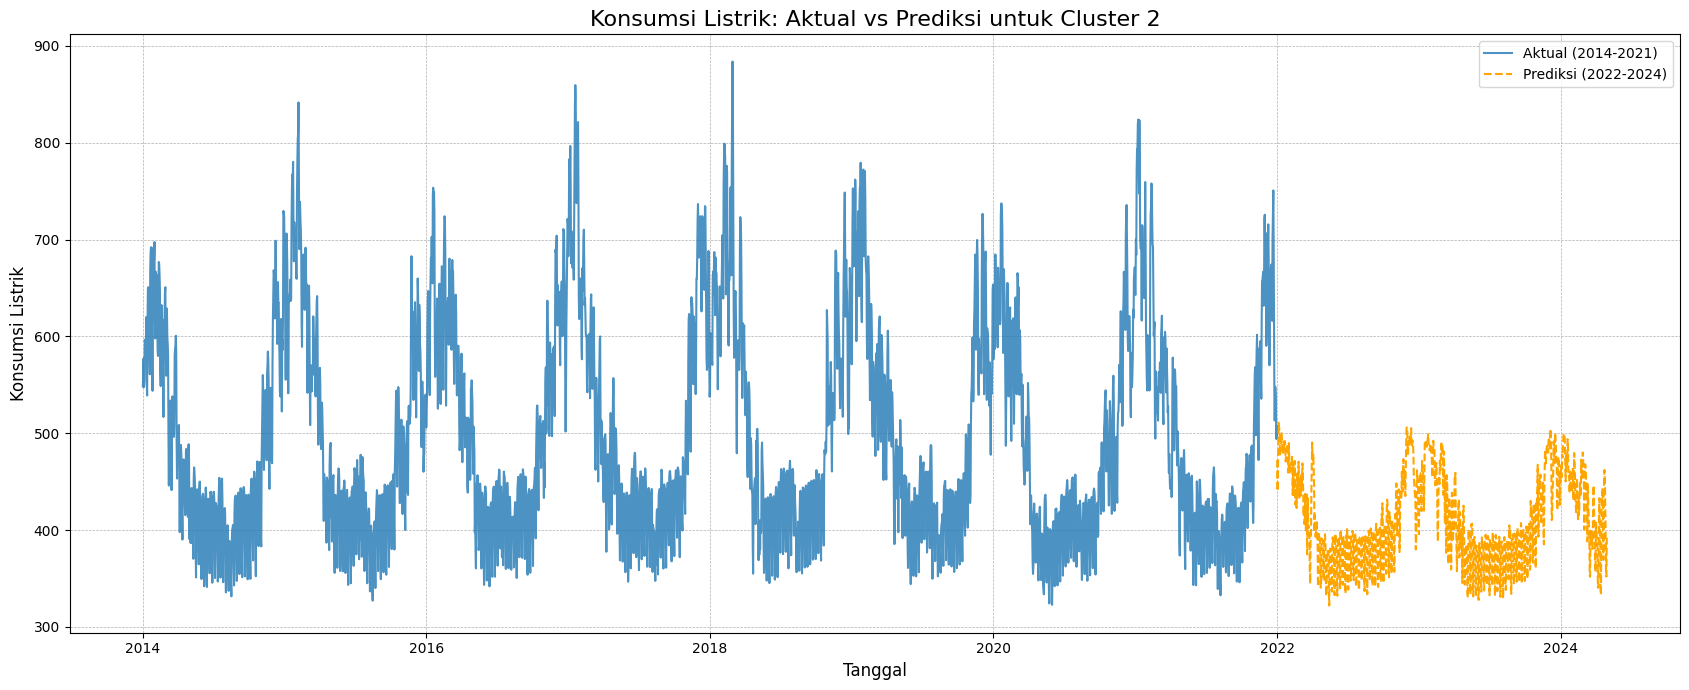

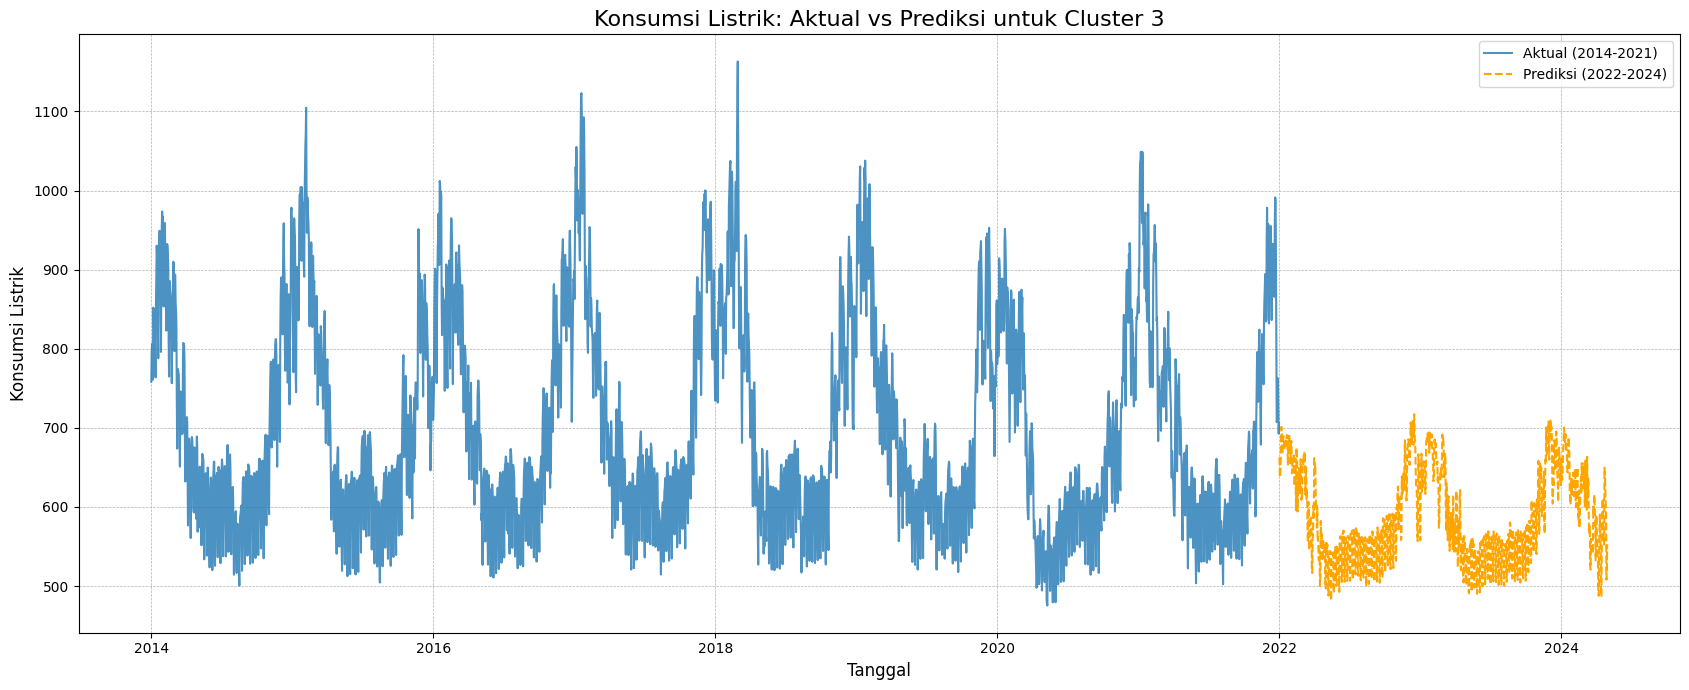

In [ ]:
# ==============================================================================
# 0️⃣ SETUP DAN LOAD DATA
# ==============================================================================
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import gc

# Pastikan Anda sudah mengunggah train.csv dan test.csv ke environment Colab/Jupyter Anda
try:
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
except FileNotFoundError:
    print("Pastikan file 'train.csv' dan 'test.csv' ada di direktori kerja.")
    # Membuat data dummy jika file tidak ditemukan, agar kode bisa berjalan untuk demonstrasi
    dates_train = pd.to_datetime(pd.date_range(start='2014-01-01', end='2021-12-31'))
    dates_test = pd.to_datetime(pd.date_range(start='2022-01-01', end='2024-05-31'))
    clusters = [f'cluster_{i}' for i in range(1, 5)]
    df_train = pd.DataFrame([(d, c) for d in dates_train for c in clusters], columns=['date', 'cluster_id'])
    df_test = pd.DataFrame([(d, c) for d in dates_test for c in clusters], columns=['date', 'cluster_id'])
    for df in [df_train, df_test]:
        df['temperature_2m_max'] = np.random.uniform(10, 35, len(df))
        df['temperature_2m_min'] = df['temperature_2m_max'] - np.random.uniform(5, 10, len(df))
        df['apparent_temperature_max'] = df['temperature_2m_max'] + np.random.uniform(0, 5, len(df))
        df['apparent_temperature_min'] = df['temperature_2m_min'] + np.random.uniform(0, 5, len(df))
        df['daylight_duration'] = np.random.uniform(40000, 45000, len(df))
    df_train['electricity_consumption'] = np.random.uniform(100, 500, len(df_train))
    df_test['ID'] = df_test['cluster_id'] + '_' + df_test['date'].dt.strftime('%Y-%m-%d')


# ==============================================================================
# 1️⃣ PRA-PEMROSESAN DATA
# ==============================================================================
print("1️⃣ Memulai Pra-pemrosesan Data...")
def preprocess_data(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['is_weekend'] = (df['date'].dt.dayofweek >= 5).astype(int)
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    return df

df_train_processed = preprocess_data(df_train.copy())
df_test_processed = preprocess_data(df_test.copy())

# ==============================================================================
# 2️⃣ FEATURE ENGINEERING (PENANGANAN LAG/ROLLING YANG AMAN)
# ==============================================================================
print("\n2️⃣ Memulai Feature Engineering...")
# Gabungkan train dan test untuk membuat fitur lag/rolling secara konsisten
# Ini mencegah data leakage karena fitur dihitung sebelum pemisahan train/val
df_test_processed['electricity_consumption'] = np.nan
combined_df = pd.concat([df_train_processed, df_test_processed], ignore_index=True)
combined_df = combined_df.sort_values(by=['cluster_id', 'date'])

# Buat fitur lag dan rolling
lags = [1, 7, 14]
windows = [7, 30]

for lag in lags:
    combined_df[f'electricity_consumption_lag_{lag}'] = combined_df.groupby('cluster_id')['electricity_consumption'].shift(lag)
for window in windows:
    combined_df[f'electricity_consumption_rolling_mean_{window}'] = combined_df.groupby('cluster_id')['electricity_consumption'].shift(1).rolling(window).mean()

# Pisahkan kembali ke train dan test
final_df = combined_df[~combined_df['electricity_consumption'].isna()].copy()
df_test_filled = combined_df[combined_df['electricity_consumption'].isna()].copy()
df_test_filled = df_test_filled.drop(columns=['electricity_consumption'])

# Hapus baris dengan NaN yang dihasilkan dari proses lag/rolling
final_df.dropna(inplace=True)

# Definisikan fitur
TARGET = 'electricity_consumption'
features = [col for col in final_df.columns if col not in ['ID', TARGET, 'date']]
categorical_features = ['cluster_id', 'year', 'month', 'dayofweek', 'is_weekend']

# CatBoost dapat menangani fitur numerik yang terlihat seperti kategori (seperti weekofyear)
# Tapi untuk kejelasan, kita akan menentukannya secara eksplisit
for col in categorical_features:
    final_df[col] = final_df[col].astype(str)
    df_test_filled[col] = df_test_filled[col].astype(str)

print("Feature engineering selesai.")

# ==============================================================================
# 3️⃣ SPLITTING VALIDASI INTERNAL
# ==============================================================================
print("\n3️⃣ Melakukan Splitting Validasi Internal...")
train_clusters = {}
val_clusters = {}

for cluster_id in final_df['cluster_id'].unique():
    cluster_data = final_df[final_df['cluster_id'] == cluster_id]
    train_split_data = cluster_data[cluster_data['date'] <= '2019-12-31']
    val_split_data = cluster_data[(cluster_data['date'] > '2019-12-31') & (cluster_data['date'] <= '2021-12-31')]

    if not train_split_data.empty and not val_split_data.empty:
        train_clusters[cluster_id] = train_split_data
        val_clusters[cluster_id] = val_split_data
        print(f"Cluster {cluster_id}: Train split = {len(train_split_data)}, Val split = {len(val_split_data)}")

# ==============================================================================
# 4️⃣ MODELING PER CLUSTER (VALIDASI)
# ==============================================================================
print("\n4️⃣ Memulai Training dan Validasi Model Per Cluster...")
cluster_models = {}
cluster_evaluation = {}

for cluster_id, train_data in train_clusters.items():
    val_data = val_clusters[cluster_id]
    print(f"Training model untuk Cluster {cluster_id}...")

    X_train, y_train = train_data[features], train_data[TARGET]
    X_val, y_val = val_data[features], val_data[TARGET]

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=8,
        loss_function='RMSE',
        eval_metric='MAE',
        random_seed=42,
        cat_features=categorical_features,
        verbose=0,
        early_stopping_rounds=50
    )
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    cluster_models[cluster_id] = model

    y_pred_val = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    cluster_evaluation[cluster_id] = {'MAE': mae, 'RMSE': rmse}
    print(f"-> Cluster {cluster_id} Validation Metrics: MAE = {mae:.4f}, RMSE = {rmse:.4f}")

# ==============================================================================
# 5️⃣ FINAL TRAINING DAN PREDIKSI
# ==============================================================================
print("\n5️⃣ Melatih Ulang Model Final dan Membuat Prediksi...")
final_cluster_models = {}
all_predictions = []

for cluster_id in final_df['cluster_id'].unique():
    print(f"Retraining dan prediksi untuk Cluster {cluster_id}...")

    full_train_data = final_df[final_df['cluster_id'] == cluster_id]
    X_full_train, y_full_train = full_train_data[features], full_train_data[TARGET]

    # Dapatkan iterasi terbaik dari model validasi
    initial_model = cluster_models.get(cluster_id)
    best_iterations = initial_model.get_best_iteration() if initial_model else 1000

    final_model = CatBoostRegressor(
        iterations=best_iterations,
        learning_rate=0.05,
        depth=8,
        loss_function='RMSE',
        random_seed=42,
        cat_features=categorical_features,
        verbose=0
    )
    final_model.fit(X_full_train, y_full_train)
    final_cluster_models[cluster_id] = final_model

    test_data_cluster = df_test_filled[df_test_filled['cluster_id'] == cluster_id]
    X_test_cluster = test_data_cluster[features]
    predictions = final_model.predict(X_test_cluster)

    pred_df = pd.DataFrame({'ID': test_data_cluster['ID'], 'electricity_consumption': predictions})
    all_predictions.append(pred_df)

# ==============================================================================
# 6️⃣ OUTPUT
# ==============================================================================
print("\n6️⃣ Membuat file submission...")
if all_predictions:
    submission_df = pd.concat(all_predictions, ignore_index=True)
    # Pastikan urutan ID sesuai dengan file test asli
    submission_df = pd.merge(df_test[['ID']], submission_df, on='ID', how='left')
    submission_df.to_csv('submission.csv', index=False)
    print("File 'submission.csv' berhasil dibuat.")
    print(submission_df.head())
else:
    print("Tidak ada prediksi yang dihasilkan.")

# Hapus variabel besar untuk membebaskan memori
del combined_df, final_df, df_test_filled, train_clusters, val_clusters, cluster_models
gc.collect()

# ==============================================================================
# 7️⃣ VISUALISASI (ROBUST VERSION)
# ==============================================================================
print("\n7️⃣ Membuat Visualisasi...")

# --- Feature Importance ---
print("\nFeature Importance per Cluster:")
for cluster_id, model in final_cluster_models.items():
    print(f"\n--- Cluster {cluster_id} ---")
    importance = model.get_feature_importance(prettified=True)
    print(importance.head(10))

# --- Plot Prediksi vs Aktual ---
print("\nPlotting Prediksi vs Aktual untuk beberapa cluster...")
num_clusters_to_plot = min(3, len(final_cluster_models))
clusters_to_plot = list(final_cluster_models.keys())[:num_clusters_to_plot]

for cluster_id in clusters_to_plot:
    plt.figure(figsize=(17, 7))

    # Plot data aktual dari file train asli
    actual_data = df_train[df_train['cluster_id'] == cluster_id]
    plt.plot(pd.to_datetime(actual_data['date']), actual_data['electricity_consumption'], label='Aktual (2014-2021)', alpha=0.8)

    # Plot data prediksi dari submission_df
    if 'submission_df' in locals() and not submission_df.empty:
        predicted_data = submission_df[submission_df['ID'].str.startswith(f'{cluster_id}_')].copy()
        if not predicted_data.empty:
            # Ekstrak tanggal dari kolom ID yang string
            predicted_data['date'] = pd.to_datetime(predicted_data['ID'].str.replace(f'{cluster_id}_', ''))
            predicted_data.sort_values('date', inplace=True)
            plt.plot(predicted_data['date'], predicted_data['electricity_consumption'], label='Prediksi (2022-2024)', color='orange', linestyle='--')

    plt.title(f'Konsumsi Listrik: Aktual vs Prediksi untuk {cluster_id.replace("_", " ").title()}', fontsize=16)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Konsumsi Listrik', fontsize=12)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
# prompt: simpan hasil prediksi ke catboost_submission.csv

# Rename the submission file
!mv submission.csv catboost_submission.csv
print("File 'submission.csv' successfully renamed to 'catboost_submission.csv'.")

File 'submission.csv' successfully renamed to 'catboost_submission.csv'.
